In [1]:
import os
import re 
import pandas as pd
import numpy as np

from typing import List, Union, Tuple
from tqdm.auto import tqdm
tqdm.pandas()


/Users/admin/opt/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dotenv import load_dotenv
load_dotenv()

OPENAI_API_KEY=os.environ["OPENAI_API_KEY"]

In [3]:
from pgvector.sqlalchemy import Vector
from sqlalchemy import create_engine, insert, select, text, Integer, String, Text
from sqlalchemy.orm import declarative_base, mapped_column, Session


In [4]:
# username = os.environ["USERNAME"]
# password = os.environ["PASSWORD"]
# hostname = os.environ["HOSTNAME"]
# database = "embedding"
# # database = os.environ["DATABASE"]
# port = os.environ["PORT"]

# db_credentials = f"postgresql://{username}:{password}@{hostname}:{port}/{database}"
POSTGRES_DBURI = os.environ["POSTGRES_DBURI"]

In [5]:
engine = create_engine(POSTGRES_DBURI)
with engine.connect() as conn:
    conn.execute(text('CREATE EXTENSION IF NOT EXISTS vector'))
    conn.commit()

Base = declarative_base()


In [6]:
df = pd.read_csv(
    "csv/ctgov_studies_20230720_openai_embedding.csv", index_col="nct_id")
df


,brief_title,official_title,overall_status,baseline_measurements,brief_summaries,detailed_descriptions,criteria,gender,minimum_age,maximum_age,facilities,city,state,zip,country,recruitment_details,pre_assignment_details,study_type,embeddings
nct_id,,,,,,,,,,,,,,,,,,,
NCT00000143,Studies of Ocular Complications of AIDS (SOCA)...,Studies of Ocular Complications of AIDS (SOCA)...,Completed,NaN,"To compare the newest CMV retinitis drug, cido...",Cytomegalovirus (CMV) is among the most freque...,Inclusion criteria:\n\nAge 13 years or older\n...,All,13 Years,NaN,"University of South Florida, MDC Box 21",Tampa,Texas,94143,United States,June 1997,NaN,Interventional,"[-0.00511028242417492, 0.009464243377397496, 0..."
NCT00000378,Antidepressant Treatment of Melancholia in Lat...,Antidepressant Treatment of Melancholia in Lat...,Completed,NaN,The purpose of this study is to compare the sa...,To compare the efficacy and safety of a select...,Inclusion Criteria:\n\n-\n\nPatients must have...,All,60 Years,95 Years,1051 Riverside Drive,New York,New York,10032,United States,NaN,NaN,Interventional,"[-0.008513840906350193, -0.009103460301146503,..."
NCT00000620,Action to Control Cardiovascular Risk in Diabe...,Action to Control Cardiovascular Risk in Diabe...,Completed,NaN,The purpose of this study is to prevent major ...,"BACKGROUND:\n\nCurrently, about 17 million Ame...",Inclusion Criteria:\n\nDiagnosed with type 2 d...,All,40 Years,79 Years,Wake Forest University,Winston-Salem,Washington,98195,United States,All participants had established type 2 diabet...,Eligible participants provided evidence of abi...,Interventional,"[-0.01889706060160469, -0.013622271110929823, ..."
NCT00001151,"Studies With 1,25-Dihydroxycholecalciferol","Studies With 1,25-Dihydroxycholecalciferol",Terminated,NaN,Vitamin D in the diet undergoes changes in the...,"Patients with extreme resistance to 1,25-dihyd...",INCLUSION CRITERIA:\n\nPatients with hereditar...,All,NaN,NaN,"National Institutes of Health Clinical Center,...",Bethesda,Maryland,20892,United States,NaN,NaN,Interventional,"[0.014962753950986616, -0.014962753950986616, ..."
NCT00001213,Cysteamine Eye Drops to Treat Corneal Crystals...,Trial of Topical Cysteamine in the Treatment o...,Completed,Although 328 participants were initially enrol...,Cystinosis is an inherited disease that result...,"Protocol 86-EI-0062 began as a randomized, dou...",INCLUSION CRITERIA:\n\nPatients must have a do...,All,2 Years,NaN,"National Institutes of Health Clinical Center,...",Bethesda,Maryland,20892,United States,NaN,NaN,Interventional,"[0.007726312115207723, -0.014869762518923454, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NCT05490771,Testing Copanlisib as a Potential Targeted Tre...,Phase II Study of Copanlisib in Patients With ...,"Active, not recruiting",NaN,This phase II MATCH treatment trial identifies...,PRIMARY OBJECTIVE:\n\nI. To evaluate the propo...,Inclusion Criteria:\n\nPatients must have met ...,All,18 Years,NaN,ECOG-ACRIN Cancer Research Group,Philadelphia,Pennsylvania,19103,United States,"Subprotocol Z1F was activated on June 20, 2018...",The PIK3CA mutations status was determined by ...,Interventional,"[-0.021477688537318147, -0.0038626280927032105..."
NCT05502081,Clinical Study to Compare Efficacy and Safety ...,Clinical Study to Evaluate the Possible Effica...,Completed,0. Uninfected\n\nAmbulatory mild disease\n\nAs...,Introduction:\n\nCorona Virus induced disease ...,I. INTRODUCTION\n\n1.1. COVID-19 overview and ...,Inclusion Criteria:\n\nage more than 12 years ...,All,12 Years,NaN,El-gomhoria St,Mansoura,El-dkhalia,050,Egypt,from 1/11/2021 to 29/5/2022 at isolation hospi...,assignment is applied after admission of parti...,Interventional,"[-0.02991733505746529, 0.010602571973073174, -..."
NCT05594173,Chewing and Oral Processing of Solid Food,Chewing and Oral Processing of Solid Food in H...,Completed,NaN,Food texture modification is commonly used as ...,Aim: To e

In [7]:
embeddings = df["embeddings"].copy()
embeddings = embeddings.progress_apply(lambda x: np.fromstring(
    re.sub(r'[\n\[\]]', '', x), sep=',').astype(np.float32)
)
embeddings[0]


  0%|          | 0/34983 [00:00<?, ?it/s]

100%|██████████| 34983/34983 [00:44<00:00, 794.33it/s] 


array([-0.00511028,  0.00946424,  0.01738859, ..., -0.0194327 ,
       -0.0226624 , -0.01445869], dtype=float32)

### Write to database

In [8]:
documents = df.to_dict(orient="records")


In [9]:
class Document(Base):
    __tablename__ = 'openai_brief_summaries'
    
    nct_id = mapped_column(String, primary_key=True)
    brief_title = mapped_column(Text)
    official_title = mapped_column(Text)
    baseline_measurements = mapped_column(Text)
    brief_summaries = mapped_column(Text)
    detailed_descriptions = mapped_column(Text)
    criteria = mapped_column(Text)
    gender = mapped_column(Text)
    minimum_age = mapped_column(Text)
    maximum_age = mapped_column(Text)
    facilities = mapped_column(Text)
    city = mapped_column(Text)
    state = mapped_column(Text)
    zip = mapped_column(Text)
    country = mapped_column(Text)
    recruitment_details = mapped_column(Text)
    pre_assignment_details = mapped_column(Text)
    study_type = mapped_column(Text)
    embedding = mapped_column(Vector(embeddings[0].shape[0]))


Base.metadata.drop_all(engine)
Base.metadata.create_all(engine)


In [10]:
documents = [
    dict(
        nct_id=df.index[i],
        brief_title=df["brief_title"].iloc[i],
        official_title=df["official_title"].iloc[i],
        baseline_measurements=df["baseline_measurements"].iloc[i],
        brief_summaries=df["brief_summaries"].iloc[i],
        detailed_descriptions=df["detailed_descriptions"].iloc[i],
        criteria=df["criteria"].iloc[i],
        gender=df["gender"].iloc[i],
        minimum_age=df["minimum_age"].iloc[i],
        maximum_age=df["maximum_age"].iloc[i],
        facilities=df["facilities"].iloc[i],
        city=df["city"].iloc[i],
        state=df["state"].iloc[i],
        zip=df["zip"].iloc[i],
        country=df["country"].iloc[i],
        recruitment_details=df["recruitment_details"].iloc[i],
        pre_assignment_details=df["pre_assignment_details"].iloc[i],
        study_type=df["study_type"].iloc[i],
        embedding=embedding
    ) for i, embedding in enumerate(embeddings)
]


In [11]:
session = Session(engine)


In [12]:
session.execute(insert(Document), documents)
session.commit()


### Clustering the trials

In [13]:
import umap
import umap.plot


/Users/admin/opt/anaconda3/envs/py310/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/admin/opt/anaconda3/envs/py310/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/admin/opt/anaconda3/envs/py310/lib/python3.10/site-packag

In [14]:
array = np.stack(embeddings)
array.shape


(34983, 1536)

In [15]:
reduced_embeddings = umap.UMAP().fit(array)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<Axes: >

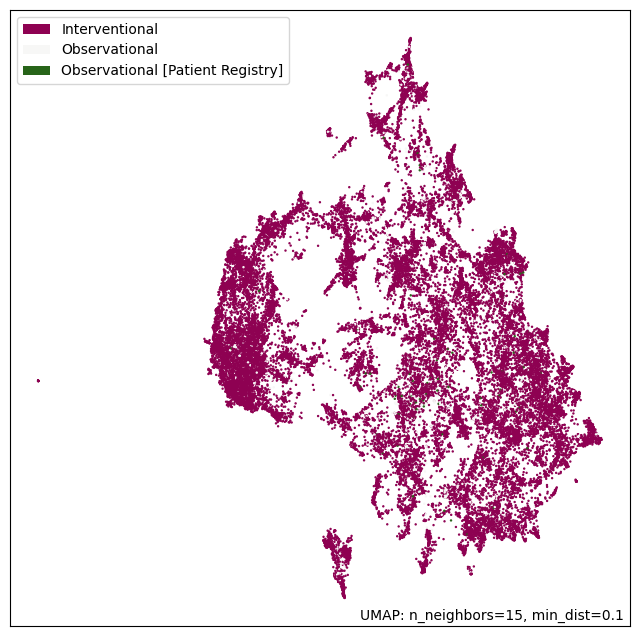

In [16]:

umap.plot.points(
    reduced_embeddings,
    labels=df["study_type"], 
    color_key_cmap='PiYG',
    )


### Search by trials

In [17]:
doc = session.get(Document, "NCT00000143")
neighbors = session.scalars(
    select(Document)
    .filter(Document.nct_id != doc.nct_id)
    .order_by(Document.embedding.cosine_distance(doc.embedding))
    .limit(5))
for neighbor in neighbors:
    print("="*80)
    print(neighbor.nct_id)
    print(neighbor.official_title)
    print(neighbor.detailed_descriptions)
    # print(neighbor.criteria)


NCT02439970
SUSTAIN: A Randomized, Double-Blind, Multicenter, Phase 3 Study of the Efficacy, Safety, and Tolerability of Brincidofovir Versus Valganciclovir for the Prevention of Cytomegalovirus Disease in High-Risk Kidney Allograft Recipients
This was a randomized, double-blind, double-dummy, parallel-group, multicenter study of the efficacy, safety, and tolerability of oral BCV versus vGCV for the prevention of CMV disease in high-risk kidney transplant allograft recipients, defined as CMV-seronegative recipients (R-) receiving a CMV-seropositive graft (D+). The study comprised a screening evaluation period (up to 14 days posttransplant), a treatment period (up to 28 weeks posttransplant), and a posttreatment follow-up period (24 weeks, through Week 52 posttransplant).
NCT01376362
The Treatment of Macular Edema Secondary to Uveitis Using Topical Interferon Gamma
Objective: Information gathered from NEI laboratories suggests that cystoid macular edema (CME) is caused by the disequilib

### Search by query

In [18]:
from scipy import spatial
import time
from langchain.embeddings import OpenAIEmbeddings


model = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)

def cosine_similarity(a, b):
    return 1 - spatial.distance.cosine(a, b)


def _generate_embedding(
    text=None,
    model=None,
    amount=0,
):
    assert model is not None
    embedding = model.embed_documents([text])
    time.sleep(amount)
    embedding = np.array(embedding).squeeze()
    return embedding

In [19]:
query = "HyperTension with Breast Cancer"

qry_embeddding = _generate_embedding(query, model=model)

print(len(qry_embeddding))
neighbors = session.scalars(
    select(Document)
    # l2 distance
    .order_by(Document.embedding.cosine_distance(qry_embeddding.tolist()))
    .limit(5))
for neighbor in neighbors:
    print("="*80)
    print(neighbor.nct_id)
    print(neighbor.official_title)
    print(neighbor.detailed_descriptions)
    # print(neighbor.criteria)


1536
NCT01733628
Evaluation Study of Hypertension as a Predictor of Efficacy Bevacizumab (BV) in Combination With Chemotherapy (CT) in Metastatic Colorectal Cancer (MCC) and Metastatic Breast Cancer (MBC).
Hypertension (HT) is the most common side effect seen in trials of bevacizumab in combination with chemotherapy. Based on the hypothesis that the development of hypertension during treatment would be an indicative of the successful blockade of the Vascular Endothelial Growth Factor (VEGF) pathway, different studies have explored retrospectively the relationship between hypertension and the results of treatment with bevacizumab.

This study aims to demonstrate the association between hypertension (diagnosed optimally) with efficacy to treatment with bevacizumab prospectively and secondly verify if blood pressure measures taken at home are a reflection of a diagnosis of hypertension.

Also have been explored different molecular markers involved in the pathway of VEGF which might be use

In [20]:
query = "Diabetes for men"

qry_embeddding = _generate_embedding(query, model=model)

print(len(qry_embeddding))
neighbors = session.scalars(
    select(Document)
    # l2 distance
    .order_by(Document.embedding.cosine_distance(qry_embeddding.tolist()))
    .limit(5))
for neighbor in neighbors:
    print("="*80)
    print(neighbor.nct_id)
    print(neighbor.official_title)
    print(neighbor.detailed_descriptions)
    # print(neighbor.criteria)


1536
NCT00504712
A Randomised, Double Blind, Placebo Controlled, Parallel Pilot Study to Test the Effect of Testosterone Treatment on Peripheral Vascular Disease in Hypogonadal Men With Type 2 Diabetes Mellitus
Testosterone treatment has shown beneficial effects on blood sugar control and obesity in pilot studies in men with type 2 diabetes. Beneficial effects have also been seen on angina- a disease related to atherosclerosis (narrowing of the arterial blood vessels). Peripheral vascular disease is also caused by atherosclerosis. We hypothesise that testosterone will have beneficial effects on peripheral vascualr disease in men with low serum testosterone and type 2 diabetes.
NCT01155518
Effect of Hypogonadotropic Hypogonadism and Replacement With Clomiphene Citrate and Testosterone on Insulin Sensitivity, Body Composition, Inflammation, Sexual Function and Spermatogenesis in Young Type 2 Diabetic Men
This project will study young men with type 2 diabetes. We have shown that half of t

In [21]:
query = "leukemia"

qry_embeddding = _generate_embedding(query, model=model)

print(len(qry_embeddding))
neighbors = session.scalars(
    select(Document)
    # l2 distance
    .order_by(Document.embedding.cosine_distance(qry_embeddding.tolist()))
    .limit(5))
for neighbor in neighbors:
    print("="*80)
    print(neighbor.nct_id)
    print(neighbor.official_title)
    print(neighbor.detailed_descriptions)
    # print(neighbor.criteria)


1536


NCT00849147
A Multi-Center, Phase II Trial of Nonmyeloablative Conditioning (NST) and Transplantation of Partially HLA-Mismatched Bone Marrow From Related Donors for Patients With Hematologic Malignancies (BMT CTN #0603)
Leukemia and lymphoma are types of blood cancers. Chemotherapy is a common treatment option for people with these types of cancers, but if the cancer does not respond well to chemotherapy, or if the cancer returns, a bone marrow transplant is another treatment option. In a bone marrow transplant procedure, healthy bone marrow is taken from a donor and transplanted into the patient. Bone marrow can be donated by a family member or an unrelated donor who has a similar type of bone marrow. Most bone marrow transplants are performed using a donor who is a perfect or close-to-perfect tissue match. However, for participants in this study, researchers have determined that a completely matched donor is unavailable within participants' families, and an unrelated donor match has